# Kernel Principal Component Analysis (KPCA) for Lung Data

## Overview
This notebook implements various Kernel PCA techniques including RBF, Polynomial, Linear, and Combined kernels for advanced dimensionality reduction on the lung microRNA dataset.

## Table of Contents
1. Data Loading and Preprocess
2. KPCA with RBF Kernel
3. KPCA with Polynomial Kernel
4. KPCA with Linear Kernel
5. KPCA with Combined Kernels
6. Kernel Comparison Analysis

## What is KPCA?
- Kernel PCA (KPCA) is like a smarter version of PCA that can find patterns even when the data isn't neatly organized in straight lines. It projects the data into a higher-dimensional space where complex, non-linear relationships become clear, then applies PCA there. This allows it to capture more intricate "summary" trends that regular PCA might miss.
- **Example:** Imagine that in lung cancer data, the relationship between gene expression and tumor size isn't a simple straight line, but a complex curve. KPCA could transform this data into a space where that curve becomes a straight line, making it possible to find a "tumor progression" principal component that accurately captures this non-linear relationship, which standard PCA couldn't.

## What are Kernels? 
- Imagine KPCA's job is to put a separating line (or curve) between different groups in the data, like separating "cancerous" from "non-cancerous" cells. The kernel is like the strategy KPCA uses to draw that line.

### 1. Linear Kernel
- **What it does:** The Linear kernel is the simplest strategy. It's like trying to draw a single, straight line to separate your data. It assumes that the patterns in your data can be found by just looking at the original features as they are.
- **When it's useful:** Use this if you suspect that the differences between cancerous and non-cancerous cells are straightforward and can be divided by a simple boundary. For example, if higher values of a few specific biomarkers directly indicate cancer.

### 2. Polynomial Kernel
- **What it does:** The Polynomial kernel is a bit more flexible. Instead of just a straight line, it can find curved or bent lines to separate your data. It does this by considering not just the original features, but also combinations and powers of those features (like if you multiply two features together).
- **When it's useful:** This is good if you think the relationship between features and cancer isn't just direct, but involves some interactions. For example, maybe a high level of biomarker A combined with a low level of biomarker B is what truly indicates cancer, rather than just high A or low B on their own.

### 3. Radial Basis Function (RBF) Kernel (also known as Gaussian Kernel)
- **What it does:** The RBF kernel is the most flexible and powerful. It's like drawing highly complex, wavy, or even circular boundaries to separate your data. It works by measuring how "similar" each data point is to others, and can find patterns even when your data points are scattered in very intricate ways.
- **When it's useful:** This is often a good starting point because it can capture very complex, non-linear relationships. If you suspect that lung cancer is caused by a highly intricate interplay of many factors that don't follow simple straight or curved lines, the RBF kernel can help KPCA find those hidden, subtle patterns.

## Dataset Information
- **Dataset**: Lung.csv
- **Features**: 1881 microRNA features
- **Samples**: 1091 lung samples
- **Task**: Non-linear dimensionality reduction using various kernels

## Author
- Raja Ram Bitra

## 2a. Data Loading and Setup

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset (assuming data is already prepared from previous notebook)
df = pd.read_csv('../Lung.csv')
data = df.iloc[:,:-1].to_numpy()
label = df.iloc[:, -1].to_numpy()

print(f"Dataset loaded: {data.shape}")

Dataset loaded: (1091, 1881)


## 2b. KPCA with RBF Kernel
- Implementation of Kernel PCA using the Radial Basis Function (RBF) kernel for non-linear dimensionality reduction. 
- This approach captures complex, non-linear relationships in the data through kernel transformations.

In [2]:
def kernel_pca_rbf(X, gamma=1.0, variance_threshold=0.95):
    # Compute RBF kernel matrix
    sq_dist = np.sum(X**2, axis=1).reshape(-1,1) + np.sum(X**2, axis=1) - 2*np.dot(X, X.T)
    K = np.exp(-gamma * sq_dist)
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    # Eigendecomposition
    eig_values, eig_vectors = np.linalg.eig(K_centered)
    
    # Sort in descending order
    sorted_indices = np.argsort(eig_values)[::-1]
    eig_values, eig_vectors = eig_values[sorted_indices], eig_vectors[:, sorted_indices]
    
    # Select components based on variance threshold
    cum_var_ratio = np.cumsum(eig_values) / np.sum(eig_values)
    n_components = np.argmax(cum_var_ratio >= variance_threshold) + 1
    
    # Project data
    red_eig_vectors = eig_vectors[:, :n_components]
    projected_data = np.dot(K_centered, red_eig_vectors)
    
    return projected_data, eig_values[:n_components], n_components

In [3]:
# Apply KPCA with RBF Kernel
print("Applying KPCA with RBF Kernel...\n")
start_time = time.time()
rbf_proj, rbf_eigs, rbf_components = kernel_pca_rbf(data, gamma=0.1)
end_time = time.time()

print("RBF Kernel PCA Results:")
print(f"Projected Data shape: {rbf_proj.shape}")
print(f"Number of components: {rbf_components}")
print(f"First 5 eigenvalues: {rbf_eigs[:5]}")
print(f"RBF KPCA Time: {end_time - start_time:.4f} seconds")

Applying KPCA with RBF Kernel...

RBF Kernel PCA Results:
Projected Data shape: (1091, 1036)
Number of components: 1036
First 5 eigenvalues: [1.00117154 1.00104944 1.00093958 1.00076876 1.00075653]
RBF KPCA Time: 3.4929 seconds


## 2c. KPCA with Polynomial Kernel
- Polynomial kernel implementation for capturing polynomial relationships in the data. 
- This kernel is effective for datasets with polynomial feature interactions.

In [4]:
def kernel_pca_polynomial(X, degree=3, coef0=1.0, variance_threshold=0.95):
    # Compute polynomial kernel matrix
    K = (X @ X.T + coef0) ** degree
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    # Eigendecomposition and component selection
    eig_values, eig_vectors = np.linalg.eig(K_centered)
    sorted_indices = np.argsort(eig_values)[::-1]
    eig_values, eig_vectors = eig_values[sorted_indices], eig_vectors[:, sorted_indices]
    
    cum_var_ratio = np.cumsum(eig_values) / np.sum(eig_values)
    n_components = np.argmax(cum_var_ratio >= variance_threshold) + 1
    
    red_eig_vectors = eig_vectors[:, :n_components]
    projected_data = np.dot(K_centered, red_eig_vectors)
    
    return projected_data, eig_values[:n_components], n_components

# Apply KPCA with Polynomial Kernel
poly_proj, poly_eigs, poly_components = kernel_pca_polynomial(data, degree=3, coef0=1.0)
print("Polynomial Kernel PCA Results:")
print(f"Projected Data shape: {poly_proj.shape}")
print(f"Number of components: {poly_components}")
print(f"First 5 eigenvalues: {poly_eigs[:5]}")

Polynomial Kernel PCA Results:
Projected Data shape: (1091, 10)
Number of components: 10
First 5 eigenvalues: [2.83226134e+36 3.97255336e+35 1.80166494e+35 1.18877682e+35
 8.13828630e+34]


## 2d. KPCA with Linear kernel
- Implementation of linear kernel KPCA (equivalent to standard PCA)

In [5]:
def kernel_pca_linear(X, variance_threshold=0.95):
    K = X @ X.T  # Linear kernel
    
    # Center and process
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    eig_values, eig_vectors = np.linalg.eig(K_centered)
    sorted_indices = np.argsort(eig_values)[::-1]
    eig_values, eig_vectors = eig_values[sorted_indices], eig_vectors[:, sorted_indices]
    
    cum_var_ratio = np.cumsum(eig_values) / np.sum(eig_values)
    n_components = np.argmax(cum_var_ratio >= variance_threshold) + 1
    
    red_eig_vectors = eig_vectors[:, :n_components]
    projected_data = np.dot(K_centered, red_eig_vectors)
    
    return projected_data, eig_values[:n_components], n_components

# Apply method
lin_proj, lin_eigs, lin_components = kernel_pca_linear(data)

print("Linear Kernel PCA Results:")
print(f"Components: {lin_components}, Shape: {lin_proj.shape}")

Linear Kernel PCA Results:
Components: 9, Shape: (1091, 9)


## 2e. KPCA with Combined Kernels ( RBF + Polynomial )
- Implementation of combined kernel approaches that leverage multiple kernel types simultaneously for enhanced feature extraction.

In [6]:
def kernel_pca_combined(X, alpha=0.5, gamma=1.0, degree=3, coef0=1.0, variance_threshold=0.95):
    # RBF kernel
    sq_dist = np.sum(X**2, axis=1).reshape(-1,1) + np.sum(X**2, axis=1) - 2*np.dot(X, X.T)
    K_rbf = np.exp(-gamma * sq_dist)
    
    # Polynomial kernel
    K_poly = (X @ X.T + coef0) ** degree
    
    # Combine kernels
    K = alpha * K_rbf + (1 - alpha) * K_poly
    
    # Center and process
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    eig_values, eig_vectors = np.linalg.eig(K_centered)
    sorted_indices = np.argsort(eig_values)[::-1]
    eig_values, eig_vectors = eig_values[sorted_indices], eig_vectors[:, sorted_indices]
    
    cum_var_ratio = np.cumsum(eig_values) / np.sum(eig_values)
    n_components = np.argmax(cum_var_ratio >= variance_threshold) + 1
    
    red_eig_vectors = eig_vectors[:, :n_components]
    projected_data = np.dot(K_centered, red_eig_vectors)
    
    return projected_data, eig_values[:n_components], n_components

# Apply method
comb_proj, comb_eigs, comb_components = kernel_pca_combined(data, alpha=0.5, gamma=0.1, degree=3, coef0=1.0)

print(f"\nCombined Kernel PCA Results:")
print(f"Components: {comb_components}, Shape: {comb_proj.shape}")


Combined Kernel PCA Results:
Components: 10, Shape: (1091, 10)


## 2f. Kernel Comparison Analysis

In [7]:
# Comprehensive comparison of all kernel methods

# Collect results from all kernel methods
kernel_results = {
    'RBF Kernel': {
        'components': rbf_components,
        'shape': rbf_proj.shape,
        'top_eigenvalues': rbf_eigs[:5],
        'total_eigenvalues': len(rbf_eigs),
        'variance_captured': '95%'
    },
    'Polynomial Kernel': {
        'components': poly_components,
        'shape': poly_proj.shape,
        'top_eigenvalues': poly_eigs[:5],
        'total_eigenvalues': len(poly_eigs),
        'variance_captured': '95%'
    },
    'Linear Kernel': {
        'components': lin_components,
        'shape': lin_proj.shape,
        'top_eigenvalues': lin_eigs[:5],
        'total_eigenvalues': len(lin_eigs),
        'variance_captured': '95%'
    },
    'Combined Kernel': {
        'components': comb_components,
        'shape': comb_proj.shape,
        'top_eigenvalues': comb_eigs[:5],
        'total_eigenvalues': len(comb_eigs),
        'variance_captured': '95%'
    }
}

# Create comparison table
print("=" * 80)
print("KERNEL PCA COMPARISON ANALYSIS")
print("=" * 80)
print(f"{'Kernel Type':<20} {'Components':<12} {'Shape':<15} {'Efficiency':<12} {'Complexity':<12}")
print("-" * 80)

for kernel_name, results in kernel_results.items():
    efficiency = "High" if results['components'] < 50 else "Medium" if results['components'] < 500 else "Low"
    complexity = "Low" if kernel_name == "Linear Kernel" else "Medium" if kernel_name == "Polynomial Kernel" else "High"
    
    print(f"{kernel_name:<20} {results['components']:<12} {str(results['shape']):<15} {efficiency:<12} {complexity:<12}")

print("\n" + "=" * 80)
print("DETAILED ANALYSIS")
print("=" * 80)

for kernel_name, results in kernel_results.items():
    print(f"\n{kernel_name}:")
    print(f"  • Components Selected: {results['components']}")
    print(f"  • Dimensionality Reduction: {data.shape[1]} → {results['components']} features")
    print(f"  • Compression Ratio: {(1 - results['components']/data.shape[1])*100:.1f}%")
    print(f"  • Top 3 Eigenvalues: {results['top_eigenvalues'][:3]}")
    
    # Calculate eigenvalue statistics
    eigenvals = results['top_eigenvalues']
    if len(eigenvals) > 1:
        eigenval_range = np.max(eigenvals) - np.min(eigenvals)
        eigenval_std = np.std(eigenvals)
        print(f"  • Eigenvalue Range: {eigenval_range:.2e}")
        print(f"  • Eigenvalue Std: {eigenval_std:.2e}")


KERNEL PCA COMPARISON ANALYSIS
Kernel Type          Components   Shape           Efficiency   Complexity  
--------------------------------------------------------------------------------
RBF Kernel           1036         (1091, 1036)    Low          High        
Polynomial Kernel    10           (1091, 10)      High         Medium      
Linear Kernel        9            (1091, 9)       High         Low         
Combined Kernel      10           (1091, 10)      High         High        

DETAILED ANALYSIS

RBF Kernel:
  • Components Selected: 1036
  • Dimensionality Reduction: 1881 → 1036 features
  • Compression Ratio: 44.9%
  • Top 3 Eigenvalues: [1.00117154 1.00104944 1.00093958]
  • Eigenvalue Range: 4.15e-04
  • Eigenvalue Std: 1.60e-04

Polynomial Kernel:
  • Components Selected: 10
  • Dimensionality Reduction: 1881 → 10 features
  • Compression Ratio: 99.5%
  • Top 3 Eigenvalues: [2.83226134e+36 3.97255336e+35 1.80166494e+35]
  • Eigenvalue Range: 2.75e+36
  • Eigenvalue Std: 1

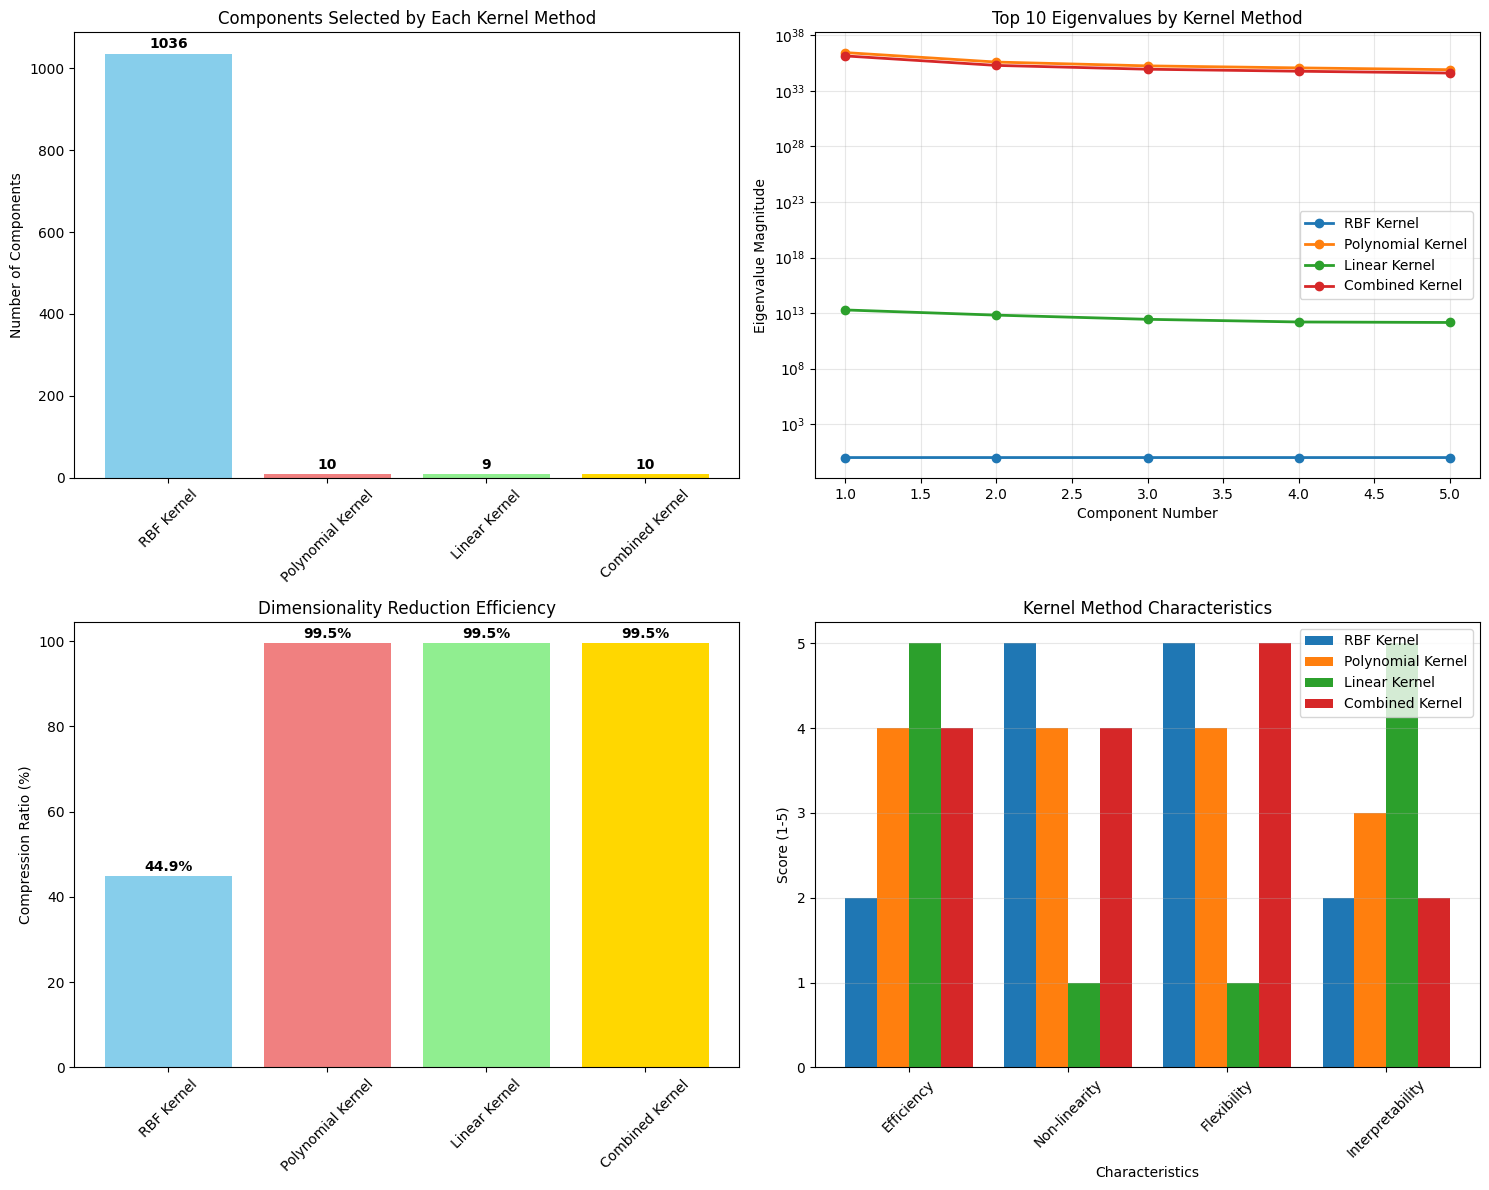

In [8]:
# Visualization of kernel comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Components Comparison
ax1 = axes[0, 0]
kernel_names = list(kernel_results.keys())
components = [kernel_results[k]['components'] for k in kernel_names]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = ax1.bar(kernel_names, components, color=colors)
ax1.set_ylabel('Number of Components')
ax1.set_title('Components Selected by Each Kernel Method')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, comp in zip(bars, components):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{comp}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Eigenvalue Magnitude Comparison
ax2 = axes[0, 1]
for i, (kernel_name, results) in enumerate(kernel_results.items()):
    eigenvals = results['top_eigenvalues'][:10]  # Top 10 eigenvalues
    ax2.plot(range(1, len(eigenvals)+1), eigenvals, 'o-', 
             label=kernel_name, linewidth=2, markersize=6)

ax2.set_xlabel('Component Number')
ax2.set_ylabel('Eigenvalue Magnitude')
ax2.set_title('Top 10 Eigenvalues by Kernel Method')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Compression Efficiency
ax3 = axes[1, 0]
compression_ratios = [(1 - kernel_results[k]['components']/data.shape[1])*100 
                     for k in kernel_names]

bars = ax3.bar(kernel_names, compression_ratios, color=colors)
ax3.set_ylabel('Compression Ratio (%)')
ax3.set_title('Dimensionality Reduction Efficiency')
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for bar, ratio in zip(bars, compression_ratios):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 4: Kernel Characteristics Radar Chart
ax4 = axes[1, 1]
characteristics = ['Efficiency', 'Non-linearity', 'Flexibility', 'Interpretability']
kernel_scores = {
    'RBF Kernel': [2, 5, 5, 2],        # Low efficiency, high non-linearity
    'Polynomial Kernel': [4, 4, 4, 3], # Medium across board
    'Linear Kernel': [5, 1, 1, 5],     # High efficiency, low complexity
    'Combined Kernel': [4, 4, 5, 2]    # Balanced but complex
}

# Simple bar chart instead of radar for better readability
x_pos = np.arange(len(characteristics))
width = 0.2
multiplier = 0

for kernel_name, scores in kernel_scores.items():
    offset = width * multiplier
    ax4.bar(x_pos + offset, scores, width, label=kernel_name)
    multiplier += 1

ax4.set_xlabel('Characteristics')
ax4.set_ylabel('Score (1-5)')
ax4.set_title('Kernel Method Characteristics')
ax4.set_xticks(x_pos + width * 1.5)
ax4.set_xticklabels(characteristics, rotation=45)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Performance and Recommendations Summary
print("\n" + "=" * 80)
print("KERNEL SELECTION RECOMMENDATIONS")
print("=" * 80)

print("\n EFFICIENCY RANKING (by dimensionality reduction):")
efficiency_ranking = sorted(kernel_results.items(), 
                          key=lambda x: x[1]['components'])
for i, (kernel_name, results) in enumerate(efficiency_ranking, 1):
    reduction = (1 - results['components']/data.shape[1])*100
    print(f"{i}. {kernel_name}: {reduction:.1f}% reduction ({results['components']} components)")

print("\n USE CASE RECOMMENDATIONS:")
print("""
Linear Kernel:
   • Best for: Simple, interpretable results
   • When to use: Baseline comparison, when linear relationships are expected
   • Pros: Fast, interpretable, equivalent to standard PCA
   • Cons: Cannot capture non-linear patterns

RBF Kernel:
   • Best for: Complex, non-linear pattern discovery
   • When to use: When data has intricate, curved relationships
   • Pros: Highly flexible, captures complex patterns
   • Cons: Computationally expensive, many components needed

Polynomial Kernel:
   • Best for: Moderate non-linearity with good efficiency
   • When to use: When polynomial relationships are suspected
   • Pros: Good balance of flexibility and efficiency
   • Cons: Sensitive to degree parameter selection

Combined Kernel:
   • Best for: Leveraging multiple pattern types
   • When to use: When uncertainty about optimal kernel type
   • Pros: Combines strengths of multiple kernels
   • Cons: More complex, requires parameter tuning
""")
print("\n" + "=" * 80)

print("\nFINAL RECOMMENDATIONS FOR LUNG CANCER DATA:")
print(f"• For EFFICIENCY: Use {efficiency_ranking[0][0]} ({efficiency_ranking[0][1]['components']} components)")
print(f"• For FLEXIBILITY: Use RBF Kernel (captures complex biomarker interactions)")
print(f"• For BALANCE: Use Polynomial Kernel (good trade-off)")
print("• For EXPLORATION: Use Combined Kernel (comprehensive analysis)")


KERNEL SELECTION RECOMMENDATIONS

 EFFICIENCY RANKING (by dimensionality reduction):
1. Linear Kernel: 99.5% reduction (9 components)
2. Polynomial Kernel: 99.5% reduction (10 components)
3. Combined Kernel: 99.5% reduction (10 components)
4. RBF Kernel: 44.9% reduction (1036 components)

 USE CASE RECOMMENDATIONS:

Linear Kernel:
   • Best for: Simple, interpretable results
   • When to use: Baseline comparison, when linear relationships are expected
   • Pros: Fast, interpretable, equivalent to standard PCA
   • Cons: Cannot capture non-linear patterns

RBF Kernel:
   • Best for: Complex, non-linear pattern discovery
   • When to use: When data has intricate, curved relationships
   • Pros: Highly flexible, captures complex patterns
   • Cons: Computationally expensive, many components needed

Polynomial Kernel:
   • Best for: Moderate non-linearity with good efficiency
   • When to use: When polynomial relationships are suspected
   • Pros: Good balance of flexibility and efficienc